# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

In [1]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.compose import make_column_transformer, TransformedTargetRegressor
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn import set_config, linear_model
set_config(display="diagram")


import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import scipy as sp

## Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

I opened the spreadsheet and scrolled down to get a general feel for the data. I looked at the categories and began
to think about their relevance and utility. Right off the bat, it is very apparent that there are a large number of
empty cells, so I will need to drop columns. Here is how I made those decisions:

1. I decided that regional data will not be helpful. Dealerships generally do not have profit margins high enough
   to purchase vehicles from far away, so they will have relatively little ability to select vehicles based on 
   regional data.
2. Included identifiers may be dropped, as that data is captured in the index
3. Columns that have categorical responses with a large number of categories can also be dropped, as they are not
   easy to encode, and large numbers of categories with relatively few entries are not useful for extracting patterns

## Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

               id       region  price    year     manufacturer  \
21171  7316895739  bakersfield  16990  2018.0          hyundai   
21172  7316894967  bakersfield   3700  2004.0           toyota   
21173  7316889135  bakersfield      0  2019.0    mercedes-benz   
21174  7316887125  bakersfield  11975  2003.0  harley-davidson   
21175  7316876945  bakersfield      0  2014.0           nissan   

                    model  condition    cylinders    fuel  odometer  \
21171  accent se sedan 4d       good          NaN     gas   16930.0   
21172          highlander       good  6 cylinders     gas  142000.0   
21173  sprinter box truck        NaN          NaN  diesel    4074.0   
21174            davidson  excellent  8 cylinders     gas  207000.0   
21175               rogue        NaN          NaN     gas   47287.0   

      title_status transmission                VIN drive       size    type  \
21171        clean        other  3KPC24A37JE034842   fwd        NaN   sedan   
21172        clean

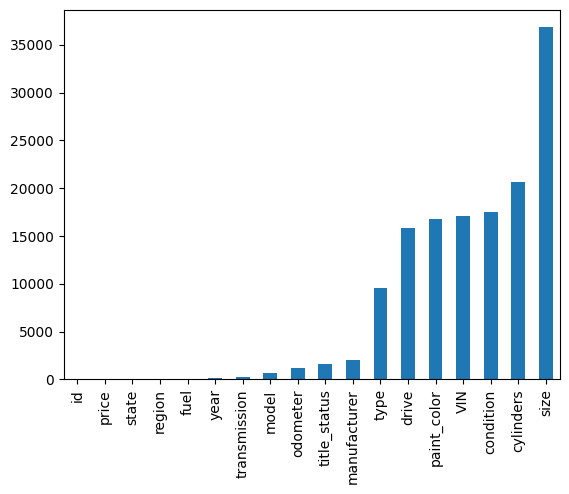

In [80]:
# Import the raw data
cars = pd.read_csv('data/vehicles_full.csv')
cars_ca = cars[(cars['state'] == 'ca')]

print(cars_ca.head())

#  I see a lot of empty cells so I ran this script:

cars_ca.isnull().sum().sort_values().plot(kind = 'bar')
plt.show();

state
ca    50614
Name: count, dtype: int64


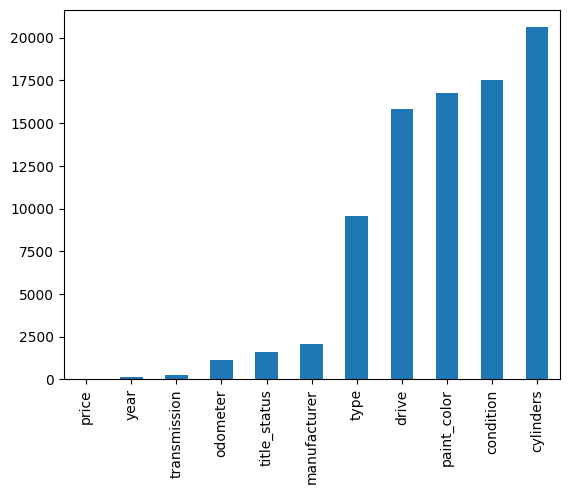

In [81]:
# I will drop 'state' first because it has too many missing values

# I then dropped the following columns because they do not provide useful data:
# 'id', 'VIN'

# Finally, I used 

####     
print(cars_ca['state'].value_counts())    ####

# to examine the columns to see how many categories were in each.
# 'region', 'model', and 'state' have a large number of categories
# so it is hard to encode them, so I dropped them as well

cars_ca = cars_ca.drop(['id','region','VIN','size','state','model','fuel'],axis=1)
cars_ca.isnull().sum().sort_values().plot(kind = 'bar')
plt.show();

In [82]:
# Now try dropping the empty cells to see what remains
cars_ca.dropna(inplace=True)

#cars.head()
#cars['fuel'].value_counts()
cars_ca.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12886 entries, 21174 to 71772
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         12886 non-null  int64  
 1   year          12886 non-null  float64
 2   manufacturer  12886 non-null  object 
 3   condition     12886 non-null  object 
 4   cylinders     12886 non-null  object 
 5   odometer      12886 non-null  float64
 6   title_status  12886 non-null  object 
 7   transmission  12886 non-null  object 
 8   drive         12886 non-null  object 
 9   type          12886 non-null  object 
 10  paint_color   12886 non-null  object 
dtypes: float64(2), int64(1), object(8)
memory usage: 1.2+ MB


In [84]:
# I got errors indicating that there are large values in the data,
# so I will drop extreme values in the three numerical categories
cars_ca = cars_ca.drop(cars_ca[cars_ca.price > 150000].index)
cars_ca = cars_ca.drop(cars_ca[cars_ca.year > 2024].index)
cars_ca = cars_ca.drop(cars_ca[cars_ca.year < 1950].index)
cars_ca = cars_ca.drop(cars_ca[cars_ca.odometer > 200000].index)
cars_ca.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11785 entries, 21178 to 71772
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         11785 non-null  int64  
 1   year          11785 non-null  float64
 2   manufacturer  11785 non-null  object 
 3   condition     11785 non-null  object 
 4   cylinders     11785 non-null  object 
 5   odometer      11785 non-null  float64
 6   title_status  11785 non-null  object 
 7   transmission  11785 non-null  object 
 8   drive         11785 non-null  object 
 9   type          11785 non-null  object 
 10  paint_color   11785 non-null  object 
dtypes: float64(2), int64(1), object(8)
memory usage: 1.1+ MB


#### The remaining data set of 108,080 clean entries is still large enough to use and should be sufficient

### Preprocessor to Scale and OneHot Encode

In [85]:
categorical_columns = ["condition", "cylinders", "drive", "paint_color","manufacturer","transmission","title_status","type"]
numerical_columns = ["year","odometer"]

preprocessor = make_column_transformer(
    (OneHotEncoder(), categorical_columns),
    (StandardScaler(), numerical_columns),
)

## Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [86]:
X = cars_ca.drop('price', axis = 1)
y = cars_ca['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)

### Model 1
Ridge Regressor, alpha=5 by experimentation

In [87]:
model1 = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=Ridge(alpha=5)
    ),
)

model1.fit(X_train,y_train)
model1_train_mse = mean_squared_error(y_train, model1.predict(X_train))
model1_test_mse = mean_squared_error(y_test, model1.predict(X_test))

print(f'Train MSE: {model1_train_mse}')
print(f'Test MSE: {model1_test_mse}')
model1

Train MSE: 90973503.89410047
Test MSE: 94235611.15658376


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['condition', 'cylinders',
                                                   'drive', 'paint_color',
                                                   'manufacturer',
                                                   'transmission',
                                                   'title_status', 'type']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['year', 'odometer'])])),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(regressor=Ridge(alpha=5)))])

In [60]:
pis1 = permutation_importance(model1, X_train, y_train, n_repeats=10,random_state=0)
column_names = list(X_train.columns)
print(column_names)

for i in range(0,len(column_names)-1):
    print(f'Importance for column {column_names[i]} is {pis1.importances_mean[i]} +/- {pis1.importances_std[i]}')

['price', 'year', 'manufacturer', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status', 'transmission', 'drive', 'type', 'paint_color']
Importance for column price is 0.10173173937052238 +/- 0.0010601262311465429
Importance for column year is 0.0284619843495983 +/- 0.0005217388885784706
Importance for column manufacturer is 0.007545701276851002 +/- 0.00030638912602440284
Importance for column condition is 0.07490297726555742 +/- 0.0010496209015779044
Importance for column cylinders is 0.07387128398882653 +/- 0.0009549801420817229
Importance for column fuel is 0.29276689404851297 +/- 0.0014150104374109054
Importance for column odometer is 0.0039171072067823 +/- 0.00010704391683631872
Importance for column title_status is 0.030309262559532712 +/- 0.0004933438073221749
Importance for column transmission is 0.022566235062047146 +/- 0.0006519436265282944
Importance for column drive is 0.04374304492155874 +/- 0.000966078231918562
Importance for column type is 0.002637217967662053 +/-

### Model 2
Lasso Regressor

In [11]:
model2 = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=Lasso(max_iter=100)
    ),
)

model2.fit(X_train,y_train)
model2_train_mse = mean_squared_error(y_train, model2.predict(X_train))
model2_test_mse = mean_squared_error(y_test, model2.predict(X_test))

#feature_names = model1.named_steps['selector'].get_feature_names_out()
#model1 = pd.DataFrame({'feature': feature_names})
#print(sequential_features_df)

print(f'Train MSE: {model2_train_mse}')
print(f'Test MSE: {model2_test_mse}')
model2

Train MSE: 127575793.62387085
Test MSE: 132968353.69255266


c:\Users\sspillane\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:639: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 608989980106.7598, tolerance: 1706622627.968672
  model = cd_fast.sparse_enet_coordinate_descent(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['condition', 'cylinders',
                                                   'fuel', 'drive',
                                                   'paint_color']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['year'])])),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(regressor=Lasso(max_iter=100)))])

### Model 3
Linear Regression

In [12]:
model3 = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=LinearRegression()
    ),
)

model3.fit(X_train,y_train)
model3_train_mse = mean_squared_error(y_train, model3.predict(X_train))
model3_test_mse = mean_squared_error(y_test, model3.predict(X_test))

#feature_names = model1.named_steps['selector'].get_feature_names_out()
#model1 = pd.DataFrame({'feature': feature_names})
#print(sequential_features_df)

print(f'Train MSE: {model3_train_mse}')
print(f'Test MSE: {model3_test_mse}')
model3

Train MSE: 127570621.64365703
Test MSE: 132954233.9966723


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['condition', 'cylinders',
                                                   'fuel', 'drive',
                                                   'paint_color']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['year'])])),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(regressor=LinearRegression()))])

In [41]:
pis1 = permutation_importance(model3, X_train, y_train, n_repeats=10,random_state=0)
column_names = list(cars.columns)

for i in range(0,len(column_names)):
    print(f'Importance for column {column_names[i]} is {pis1.importances_mean[i]} +/- {pis1.importances_std[i]}')

Importance for column price is 0.10177352760326555 +/- 0.0010495709213004007
Importance for column year is 0.03098921123039152 +/- 0.0005849313021500454
Importance for column manufacturer is 0.00755658294676208 +/- 0.0003061208971172528
Importance for column condition is 0.07478376656583796 +/- 0.0010544872854024734
Importance for column cylinders is 0.07390821335598804 +/- 0.0009621101764316368
Importance for column fuel is 0.2920200199479395 +/- 0.001423541705984297
Importance for column odometer is 0.003956164152072972 +/- 0.00010692273147619013
Importance for column title_status is 0.03041108547425142 +/- 0.000494229567789773
Importance for column transmission is 0.02229199269276071 +/- 0.0006470163223304853
Importance for column drive is 0.04386524504031839 +/- 0.0009740411855042499
Importance for column type is 0.00265719355593681 +/- 0.00015551969556472513


IndexError: index 11 is out of bounds for axis 0 with size 11

## Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

Both models say that the most important columns are:

1. Odometer         29.3%
2. Year             10.2%
3. Cylinders        7.5%
4. Fuel Type        7.4%
5. Car body type    4.4%

The least important columns are:

10. Title status    0.4%
9. Condition        0.7%
8. Drivetrain       2.3%
7. Manufacturer     2.8%
6. Transmission     3.0%



In [ ]:
# Both models say that the most important columns are:



### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.